# TAsk - 2 (Add Accuracy Block)

- Basic DCGAN implementation for MNIST like image generation
- Possible enhancement can be 1.better initialization of generator's and discriminator's layers 2. Using better Betas for Adam 3. More Epochs 4. Working on Generator for reducing its loss

In [1]:
import torch.nn as nn
from torch.utils.data import DataLoader
from torchvision import datasets
import torchvision.transforms as transforms
from torch import optim
import torch
from matplotlib import pyplot as plt

In [2]:
if torch.cuda.is_available():
    device=torch.device(type='cuda',index=0)
else:
    device=torch.device(type='cpu',index=0)

In [3]:
train_data=datasets.MNIST(root='/kaggle/temp/mnist_train', train=True, download=True, transform=transforms.Compose([transforms.Resize(32), transforms.ToTensor(),transforms.Normalize([0.5],[0.5])]))

100%|██████████| 9912422/9912422 [00:00<00:00, 99455572.27it/s]


Extracting /kaggle/temp/mnist_train/MNIST/raw/train-images-idx3-ubyte.gz to /kaggle/temp/mnist_train/MNIST/raw



100%|██████████| 28881/28881 [00:00<00:00, 45267449.11it/s]


Extracting /kaggle/temp/mnist_train/MNIST/raw/train-labels-idx1-ubyte.gz to /kaggle/temp/mnist_train/MNIST/raw



100%|██████████| 1648877/1648877 [00:00<00:00, 26936076.04it/s]


Extracting /kaggle/temp/mnist_train/MNIST/raw/t10k-images-idx3-ubyte.gz to /kaggle/temp/mnist_train/MNIST/raw



100%|██████████| 4542/4542 [00:00<00:00, 11803301.59it/s]


Extracting /kaggle/temp/mnist_train/MNIST/raw/t10k-labels-idx1-ubyte.gz to /kaggle/temp/mnist_train/MNIST/raw



In [4]:
batch_size=64

In [6]:
train_dataloader=DataLoader(dataset=train_data, batch_size=batch_size, shuffle=True)

In [7]:
def convblock(in_channels,out_channels,kernel_size=4,stride=2,padding=1):
    layers=[nn.Conv2d(in_channels,out_channels,kernel_size,stride,padding)]
    layers.append(nn.BatchNorm2d(num_features=out_channels))
    layers.append(nn.LeakyReLU(0.2))
    return nn.Sequential(*layers)

def tconvblock(in_channels,out_channels,kernel_size=4,stride=2,padding=1):
    layers=[nn.ConvTranspose2d(in_channels,out_channels,kernel_size,stride,padding)]
    layers.append(nn.BatchNorm2d(num_features=out_channels))
    layers.append(nn.ReLU())
    layers.append(nn.Dropout2d(0.25))
    return nn.Sequential(*layers)

In [8]:
class Generator(nn.Module):
    def __init__(self,latent_dim, img_size):
        super().__init__()
        self.latent_dim=latent_dim
        self.img_size=img_size
        self.init_size=self.img_size//4

        self.lin=nn.Linear(in_features=self.latent_dim,out_features=128*self.init_size*self.init_size )

        self.tconvblocks=nn.Sequential(tconvblock(128,64,4,2,1),tconvblock(64,32,4,2,1))

        self.convtanh=nn.Sequential(nn.Conv2d(32,1,3,1,1),nn.Tanh())


    def forward(self,x):
        x=self.lin(x)
        x=x.view(x.shape[0],128,self.init_size,self.init_size)
        x=self.tconvblocks(x)
        x=self.convtanh(x)

        return x

class Discriminator(nn.Module):
    def __init__(self, img_size):
        super().__init__()

        self.img_size=img_size

        self.convblocks=nn.Sequential(convblock(1,16,4,2,1), convblock(16,32,4,2,1), convblock(32,64,4,2,1),convblock(64,128,4,2,1))

        self.out=nn.Sequential(nn.Linear(128*(self.img_size//(2**(len(self.convblocks)-1))),2))

    def forward(self,x):
        x=self.convblocks(x)
        x=x.view(x.shape[0],-1)
        pred=self.out(x)
        return pred

In [9]:
loss_fn=nn.CrossEntropyLoss().to(device)
n_epochs=5 #actually, you should run for more epochs, may be 200
lr=0.0002

generator=Generator(100,32).to(device)
discriminator=Discriminator(32).to(device)

gopt=optim.Adam(params=generator.parameters(),lr=lr)
dopt=optim.Adam(params=discriminator.parameters(),lr=lr)

In [13]:
def train_one_epoch(plt, epoch):
    total_correct = 0
    total_samples = 0
    for i, (imgs, _) in enumerate(train_dataloader):

        noise_vectors = torch.randn((imgs.shape[0], 100)).to(device)

        zero_labels = torch.zeros((imgs.shape[0])).to(device).type(torch.int64)
        one_labels = torch.ones((imgs.shape[0])).to(device).type(torch.int64)

        fake_images = generator(noise_vectors)

        pred = discriminator(fake_images)

        gloss = loss_fn(pred, one_labels)

        gopt.zero_grad()
        gloss.backward()
        gopt.step()

        real_imgs = imgs.to(device)

        pred_on_real = discriminator(real_imgs)
        dloss_on_real = loss_fn(pred_on_real, one_labels)
        pred_on_fake = discriminator(fake_images.detach())
        dloss_on_fake = loss_fn(pred_on_fake, zero_labels)
        dloss = (dloss_on_real + dloss_on_fake) / 2

        dopt.zero_grad()
        dloss.backward()
        dopt.step()

        # Accuracy Block 
        with torch.no_grad():
            pred_labels = torch.argmax(pred_on_real, dim=1)
            correct = torch.sum(pred_labels == one_labels)
            total_correct += correct.item()
            total_samples += imgs.size(0)

        if i % 500 == 0:
            print("Batch No.:", i + 1, "/", len(train_dataloader), ":", "GLoss=", round(gloss.item(), 4), "DLoss=",
                  round(dloss.item(), 4))

    # Print accuracy at the end of the epoch
    epoch_accuracy = total_correct / total_samples
    print(f"Epoch {epoch}: Discriminator Accuracy = {epoch_accuracy}")

    # Optionally, visualize generated images
    batch_size = min(64, fake_images.size(0))  # Ensure batch_size is not larger than the number of generated images
    plt.figure(figsize=(10, 5))
    plt.title("Generated Images")
    for j in range(batch_size):
        plt.subplot(8, 8, j + 1)
        plt.imshow(torch.permute(fake_images[j], (1, 2, 0)).detach().cpu(), interpolation='nearest', cmap='gray_r')
    plt.show()

Epoch 1 / 5 :
Batch No.: 1 / 938 : GLoss= 7.9014 DLoss= 0.0399
Batch No.: 501 / 938 : GLoss= 4.4726 DLoss= 0.0134
Epoch 1: Discriminator Accuracy = 0.98315


/tmp/ipykernel_34/709033043.py:53: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  plt.subplot(8, 8, j + 1)


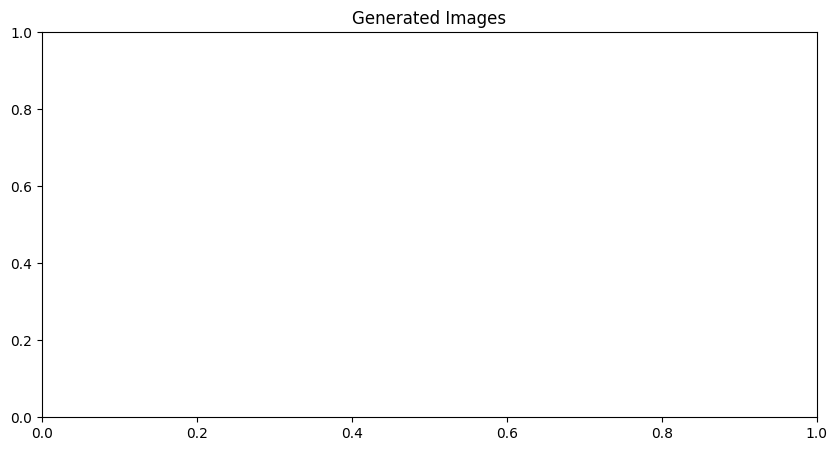

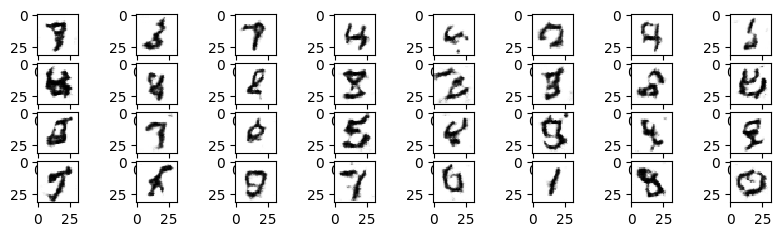

Epoch 2 / 5 :
Batch No.: 1 / 938 : GLoss= 7.2649 DLoss= 1.8733
Batch No.: 501 / 938 : GLoss= 8.1704 DLoss= 0.0242
Epoch 2: Discriminator Accuracy = 0.9941333333333333


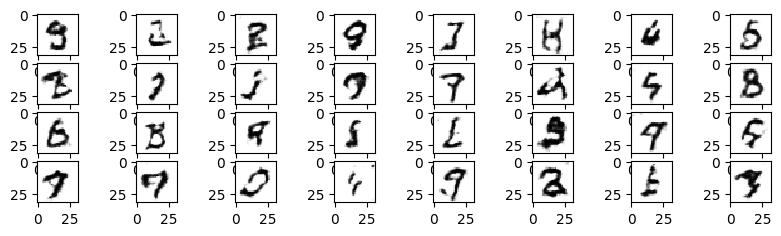

Epoch 3 / 5 :
Batch No.: 1 / 938 : GLoss= 7.908 DLoss= 0.0107
Batch No.: 501 / 938 : GLoss= 6.3991 DLoss= 0.007
Epoch 3: Discriminator Accuracy = 0.9859166666666667


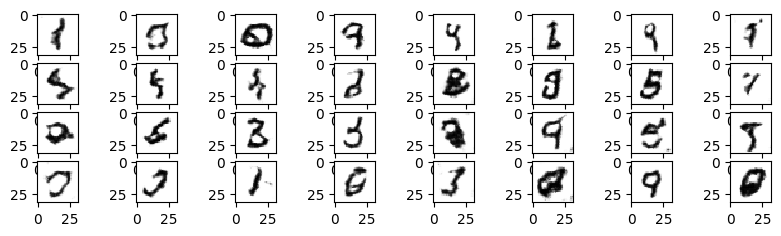

Epoch 4 / 5 :
Batch No.: 1 / 938 : GLoss= 5.0927 DLoss= 0.0066
Batch No.: 501 / 938 : GLoss= 9.3377 DLoss= 0.005
Epoch 4: Discriminator Accuracy = 0.99315


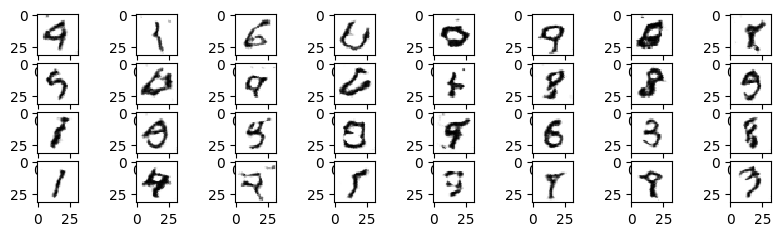

Epoch 5 / 5 :
Batch No.: 1 / 938 : GLoss= 3.4133 DLoss= 0.0289
Batch No.: 501 / 938 : GLoss= 5.016 DLoss= 0.0064
Epoch 5: Discriminator Accuracy = 0.9892166666666666


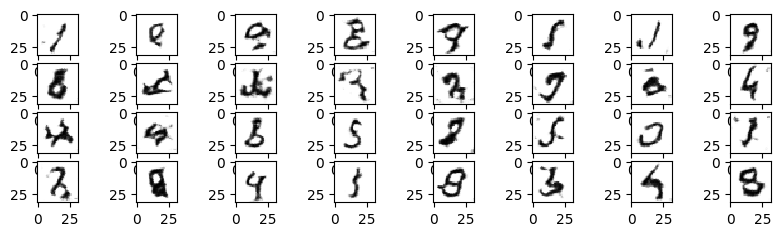

In [14]:
plt.figure(figsize=(10, 5))
plt.title("Generated Images")
for e in range(n_epochs):
    print("Epoch", e + 1, "/", n_epochs, ":")
    train_one_epoch(plt, e + 1)

Inside the train_one_epoch function, after computing the discriminator's predictions (pred_on_real), I calculate the number of correct predictions by comparing the predicted labels with the ground truth labels (one_labels).

The number of correct predictions is accumulated in the total_correct variable.

Additionally, I keep track of the total number of samples processed in the total_samples variable.

At the end of each epoch, I divide the total number of correct predictions (total_correct) by the total number of samples processed (total_samples) to compute the accuracy.
This accuracy value represents the percentage of correct predictions made by the discriminator on the real images during the epoch.

# Taks-2 Change the Generator Architecture and Add one more transposeConv

In [19]:
import torch.nn as nn
from torch.utils.data import DataLoader
from torchvision import datasets
import torchvision.transforms as transforms
from torch import optim
import torch
from matplotlib import pyplot as plt

In [20]:
if torch.cuda.is_available():
    device = torch.device(type='cuda', index=0)
else:
    device = torch.device(type='cpu', index=0)

In [21]:
train_data = datasets.MNIST(root='./data', train=True, download=True,
                            transform=transforms.Compose([transforms.Resize(32),
                                                          transforms.ToTensor(),
                                                          transforms.Normalize([0.5], [0.5])]))

100%|██████████| 9912422/9912422 [00:00<00:00, 98116782.92it/s]


Extracting ./data/MNIST/raw/train-images-idx3-ubyte.gz to ./data/MNIST/raw



100%|██████████| 28881/28881 [00:00<00:00, 50097474.70it/s]

Extracting ./data/MNIST/raw/train-labels-idx1-ubyte.gz to ./data/MNIST/raw




100%|██████████| 1648877/1648877 [00:00<00:00, 22973940.97it/s]


Extracting ./data/MNIST/raw/t10k-images-idx3-ubyte.gz to ./data/MNIST/raw



100%|██████████| 4542/4542 [00:00<00:00, 8986098.48it/s]


Extracting ./data/MNIST/raw/t10k-labels-idx1-ubyte.gz to ./data/MNIST/raw



In [22]:
batch_size = 64

In [23]:
train_dataloader = DataLoader(dataset=train_data, batch_size=batch_size, shuffle=True)

In [28]:
class Generator(nn.Module):
    def __init__(self, latent_dim, img_size):
        super(Generator, self).__init__()
        self.latent_dim = latent_dim
        self.img_size = img_size
        self.init_size = img_size // 8
        
        self.lin = nn.Linear(latent_dim, 128 * self.init_size * self.init_size)
        
        self.tconvblocks = nn.Sequential(
            nn.BatchNorm2d(128),
            nn.ReLU(),
            nn.ConvTranspose2d(128, 64, 4, stride=2, padding=1),
            nn.BatchNorm2d(64),
            nn.ReLU(),
            nn.ConvTranspose2d(64, 32, 4, stride=2, padding=1),
            nn.BatchNorm2d(32),
            nn.ReLU(),
            nn.ConvTranspose2d(32, 16, 4, stride=2, padding=1),
            nn.BatchNorm2d(16),
            nn.ReLU(),
            nn.ConvTranspose2d(16, 1, 4, stride=2, padding=1),
            nn.Tanh()
        )

    def forward(self, z):
        x = self.lin(z)
        x = x.view(x.size(0), 128, self.init_size, self.init_size)
        x = self.tconvblocks(x)
        return x

class Discriminator(nn.Module):
    def __init__(self, img_size):
        super(Discriminator, self).__init__()
        self.img_size = img_size

        self.convblocks = nn.Sequential(
            nn.Conv2d(1, 16, 4, stride=2, padding=1),
            nn.BatchNorm2d(16),
            nn.LeakyReLU(0.2),
            nn.Conv2d(16, 32, 4, stride=2, padding=1),
            nn.BatchNorm2d(32),
            nn.LeakyReLU(0.2),
            nn.Conv2d(32, 64, 4, stride=2, padding=1),
            nn.BatchNorm2d(64),
            nn.LeakyReLU(0.2),
            nn.Conv2d(64, 128, 4, stride=2, padding=1),
            nn.BatchNorm2d(128),
            nn.LeakyReLU(0.2)
        )
        # Calculate the flattened input size
        self.fc_size = 128 * (img_size // 16) * (img_size // 16)
        self.out = nn.Linear(self.fc_size, 1)

    def forward(self, x):
        x = self.convblocks(x)
        x = x.view(x.size(0), -1)
        x = self.out(x)
        return x


In [29]:
loss_fn = nn.BCEWithLogitsLoss()
lr = 0.0002
n_epochs = 5
generator = Generator(100, 32).to(device)
discriminator = Discriminator(32).to(device)

gopt = optim.Adam(generator.parameters(), lr=lr)
dopt = optim.Adam(discriminator.parameters(), lr=lr)

In [30]:
def train_one_epoch(plt, epoch):
    for i, (real_imgs, _) in enumerate(train_dataloader):
        real_imgs = real_imgs.to(device)
        batch_size = real_imgs.size(0)

        # Train Generator
        noise = torch.randn(batch_size, 100).to(device)
        fake_imgs = generator(noise)
        g_loss = loss_fn(discriminator(fake_imgs), torch.ones(batch_size, 1).to(device))

        generator.zero_grad()
        g_loss.backward()
        gopt.step()

        # Train Discriminator
        real_output = discriminator(real_imgs)
        fake_output = discriminator(fake_imgs.detach())

        d_real_loss = loss_fn(real_output, torch.ones(batch_size, 1).to(device))
        d_fake_loss = loss_fn(fake_output, torch.zeros(batch_size, 1).to(device))
        d_loss = (d_real_loss + d_fake_loss) / 2

        discriminator.zero_grad()
        d_loss.backward()
        dopt.step()

        if i % 500 == 0:
            print(f"Epoch {epoch}/{n_epochs}, Batch {i}/{len(train_dataloader)}")
            print(f"  Generator Loss: {g_loss.item()}, Discriminator Loss: {d_loss.item()}")
            plt.imshow(fake_imgs[0].cpu().detach().squeeze().numpy(), cmap='gray')
            plt.show()